# 02: Understanding the data

This notebook contains all of the information necessary for understanding the data, its descriptive statistics and plotting light curves.

In [106]:
# importing all of the necessary libraries
import numpy as np
import matplotlib
import seaborn as sns
import pandas as pd

from matplotlib import pyplot as plt
from scipy.stats import norm

from astroML.utils.decorators import pickle_results
from astroML.time_series import search_frequencies, lomb_scargle, MultiTermFit
from astroML.datasets import fetch_LINEAR_sample

np.random.seed(42)
%matplotlib inline  

In [107]:
sns.set_theme() # setting the theme for plotting

# LINEAR data

### A bit about LINEAR

## Downloading the data

Downloading the data only requires one line of code, since we are downloading the data from the AstroMl library.

In [8]:
# fetching the data and saving it in the inputs folder
data = fetch_LINEAR_sample(data_home='/Users/emadonev/Library/Mobile Documents/com~apple~CloudDocs/PROJECTS/var_stars/inputs') # fetching the data from astroML data library

[=========================================]  303.4kb / 303.4kb   
[=========================================]  16.05Mb / 16.05Mb   


We are accessing the data throught the `AstroML` library, since the creators of the library have already organised and prepared the data.

In [9]:
# acessing all of the light curves from the data and checking if any light curve is missing
c = 0 # setting the counter to 0
for i in data.ids: # iterating through all of the data ID's
    light_curve = data.get_light_curve(i) # fetching the light curve data for a specific ID
    c += 1 # updating the counter
    print(light_curve[:1]) # printing the first row of the light curve
print(c) # printing the result of the counter

[[5.26514326e+04 1.57560000e+01 3.50000000e-02]]
[[5.26524776e+04 1.65340000e+01 5.90000000e-02]]
[[5.26374598e+04 1.54500000e+01 4.48000000e-01]]
[[5.26524564e+04 1.48020000e+01 1.10000000e-02]]
[[5.2652457e+04 1.3849000e+01 6.0000000e-03]]
[[5.26524571e+04 1.57110000e+01 2.60000000e-02]]
[[5.26644199e+04 1.60240000e+01 8.90000000e-02]]
[[5.26534613e+04 1.54790000e+01 2.00000000e-02]]
[[5.26534613e+04 1.50940000e+01 1.30000000e-02]]
[[5.26534612e+04 1.57050000e+01 2.40000000e-02]]
[[5.26534612e+04 1.60910000e+01 3.50000000e-02]]
[[5.26534609e+04 1.51110000e+01 1.70000000e-02]]
[[5.26534617e+04 1.69120000e+01 6.70000000e-02]]
[[5.26534608e+04 1.53420000e+01 1.70000000e-02]]
[[5.26534607e+04 1.50940000e+01 1.30000000e-02]]
[[5.26534608e+04 1.57890000e+01 2.80000000e-02]]
[[5.26134521e+04 1.67090000e+01 7.80000000e-02]]
[[5.26134521e+04 1.61110000e+01 4.40000000e-02]]
[[5.26675229e+04 1.65260000e+01 8.40000000e-02]]
[[5.26464943e+04 1.74710000e+01 1.58000000e-01]]
[[5.2646479e+04 1.54980

The counter has printed the number `7010`, which is the correct amount of light curves in this dataset. This means no light curves are missing!

Our data contains 3 columns: `time`, `magnitude` and `magnitude_error`.

## Descriptive statistics of light curves

Before we begin with the calculation of periods and with analyzing the data, it is important to understand how it looks like. We accomplish this using **descriptive statistics*. Here, we are going to look at the statistics of `magnitude` values and `magnitude_error` values. The quantities are the `mean`, `median`, `standard deviation`, `minimum`, and `maximum`.

#### Creating a descriptive statistics table for Magnitude values

In [57]:
descriptive_stats_mag = pd.DataFrame() # creating an empty DataFrame where all of the stats will go

In [58]:
for i in data.ids: # looping over the id's of the dataset
    light_curve = data.get_light_curve(i) # getting the light curve information
    df = pd.DataFrame(light_curve.T[1], columns=[i]) # creating a table for every light curve
    dt = df.agg([np.mean, np.median, np.std, np.min, np.max]) # calculating the statistics for every value in the magnitudes column
    dt = dt.transpose() # transpose the table so the statistics are the columns and the ID of every light curve the row
    descriptive_stats_mag = pd.concat([descriptive_stats_mag, dt], axis=0) # add the data to the existing table
descriptive_stats_mag # print the table

,mean,median,std,min,max
10003298,15.920224,15.8880,0.159858,15.679,16.360
10004892,16.839543,16.8440,0.236847,16.382,17.975
10013411,15.574235,15.5020,0.192148,15.400,16.391
10021274,14.939383,14.9885,0.231373,14.289,15.330
10022663,14.253744,14.2935,0.227889,13.698,14.665
...,...,...,...,...,...
9983476,16.105178,16.2230,0.269350,15.256,16.447
9983939,15.392084,15.3705,0.146921,15.021,15.666
9984569,16.878944,16.8865,0.185500,16.015,17.461
9987252,16.536356,16.6190,0.233660,15.898,17.009


#### Creating a descriptive statistics table for Error values

In [59]:
descriptive_stats_error = pd.DataFrame() # creating an empty DataFrame where all of the stats will go

In [60]:
# repeating the same process with the error values
for i in data.ids: 
    light_curve_error = data.get_light_curve(i) 
    dfe = pd.DataFrame(light_curve_error.T[2], columns=[i])
    dte = dfe.agg([np.mean, np.median, np.std, np.min, np.max])
    dte = dte.transpose()
    descriptive_stats_error = pd.concat([descriptive_stats_error, dte], axis=0)

In [61]:
# adding the name 'index' to the column of indexes
descriptive_stats_mag.index.name='index'
descriptive_stats_error.index.name='index'

### Adding a maximum amplitude column to the data

In [80]:
descriptive_stats_mag['Amplitude'] = descriptive_stats_mag['max'] - descriptive_stats_mag['min']
descriptive_stats_error['Amplitude'] = descriptive_stats_error['max'] - descriptive_stats_error['min']


## Analyzing descriptive statistics of light curves

### Magnitude values

In [69]:
# the list of columns
columns = ['mean', 'median', 'std', 'min', 'max', 'Amplitude']

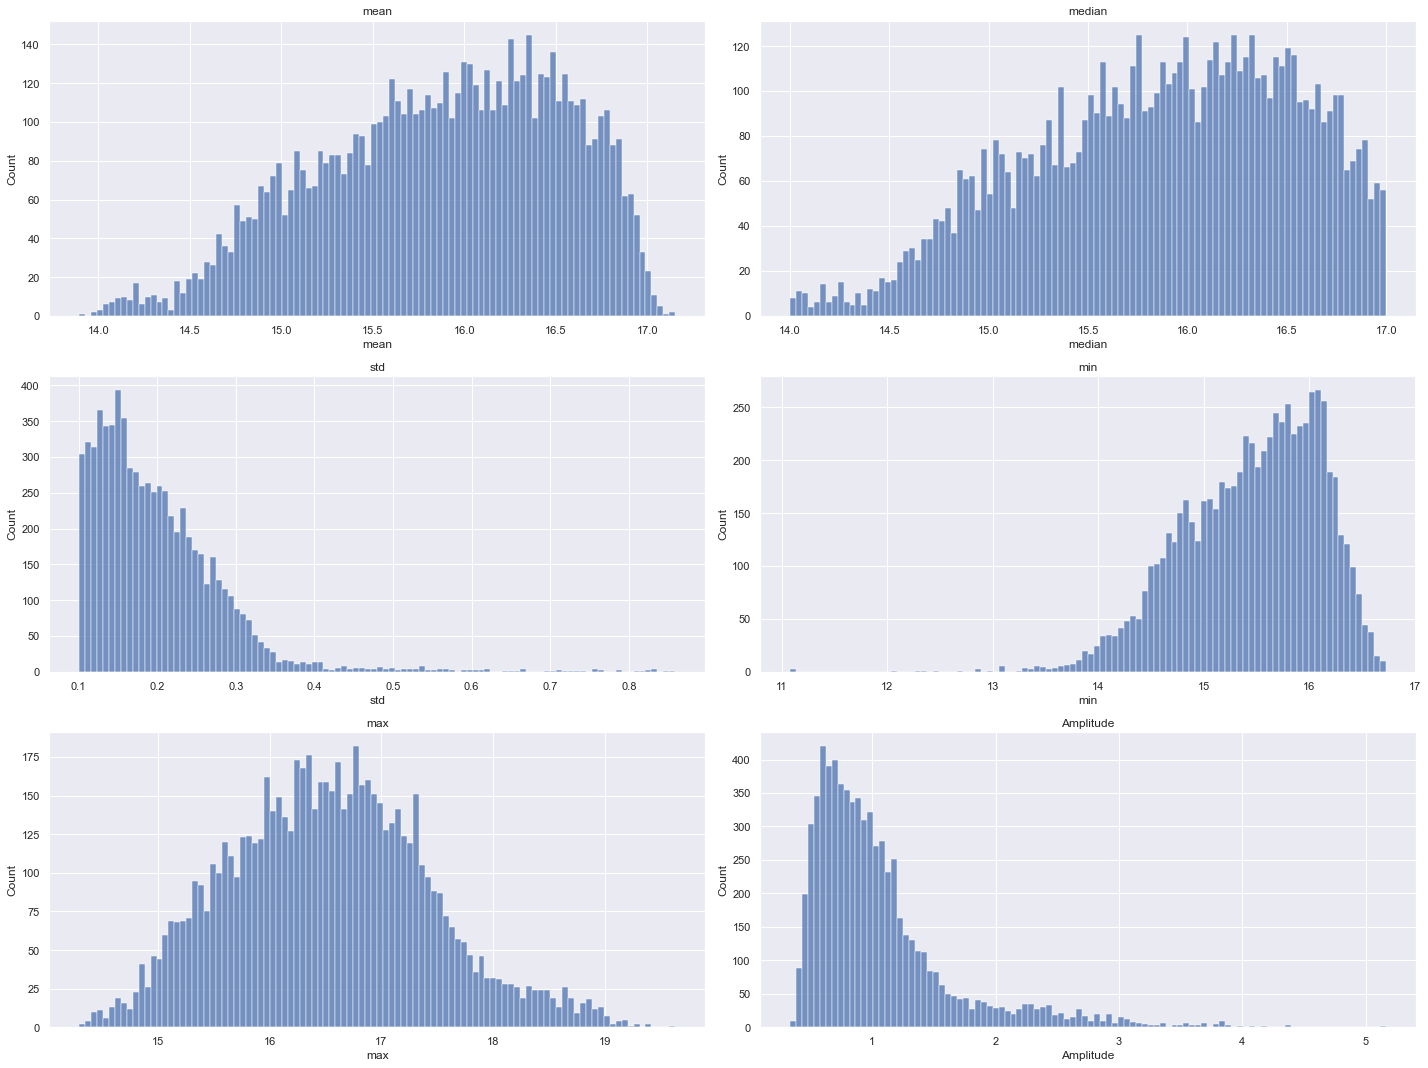

In [70]:
fig, ax = plt.subplots(3,2, figsize=(20,15)) # creating subplots with 2 columms and 3 rows
ax = ax.flatten() # flatten the axes
for i in range(len(columns)): #plot the same type of graph for every property
    ax[i].set_title(columns[i])
    sns.histplot(data=descriptive_stats_mag,x=columns[i],bins=100,ax=ax[i])
plt.tight_layout()
plt.show()

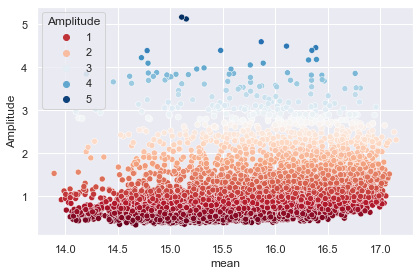

In [74]:
sns.scatterplot(
        data=descriptive_stats_mag,
        x='mean',
        y='Amplitude',
        palette='RdBu',
        hue='Amplitude')
plt.tight_layout()
plt.show()

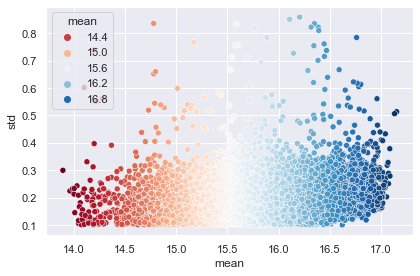

In [75]:
sns.scatterplot(
        data=descriptive_stats_mag,
        x='mean',
        y='std',
        palette='RdBu',
        hue='mean')
plt.tight_layout()
plt.show()

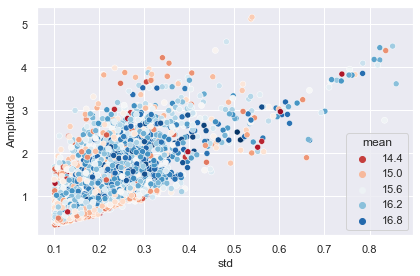

In [77]:
sns.scatterplot(
        data=descriptive_stats_mag,
        x='std',
        y='Amplitude',
        palette='RdBu',
        hue='mean')
plt.tight_layout()
plt.show()

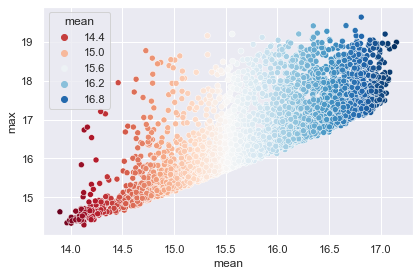

In [78]:
sns.scatterplot(
        data=descriptive_stats_mag,
        x='mean',
        y='max',
        palette='RdBu',
        hue='mean')
plt.tight_layout()
plt.show()

## Error values

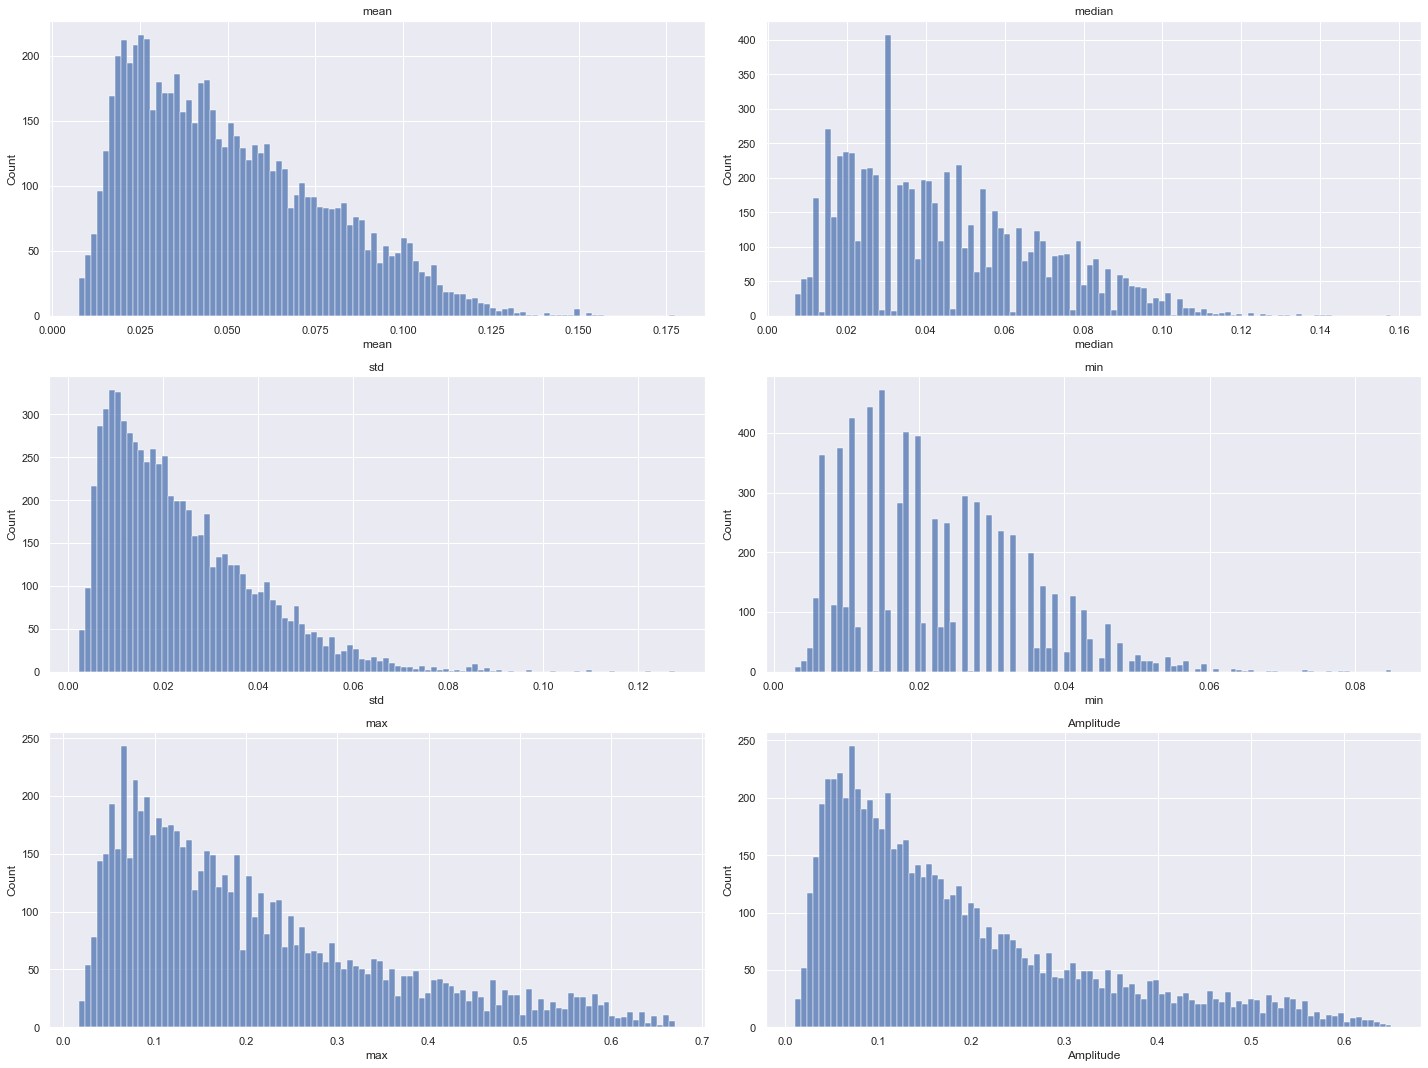

In [81]:
fig, ax = plt.subplots(3,2, figsize=(20,15)) # creating subplots with 2 columms and 3 rows
ax = ax.flatten() # flatten the axes
for i in range(len(columns)): #plot the same type of graph for every property
    ax[i].set_title(columns[i])
    sns.histplot(data=descriptive_stats_error,x=columns[i],bins=100,ax=ax[i])
plt.tight_layout()
plt.show()

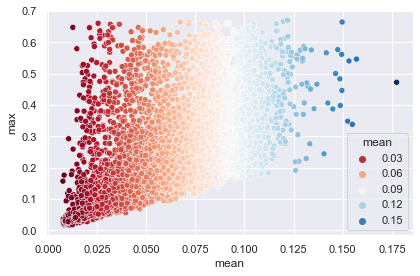

In [82]:
sns.scatterplot(
        data=descriptive_stats_error,
        x='mean',
        y='max',
        palette='RdBu',
        hue='mean')
plt.tight_layout()
plt.show()

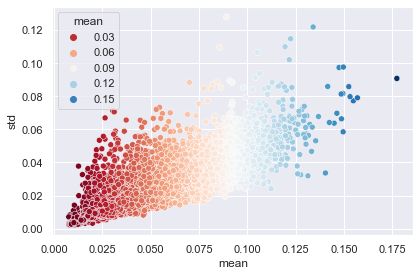

In [83]:
sns.scatterplot(
        data=descriptive_stats_error,
        x='mean',
        y='std',
        palette='RdBu',
        hue='mean')
plt.tight_layout()
plt.show()

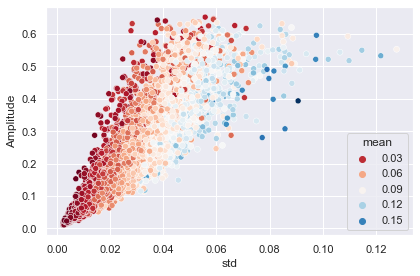

In [84]:
sns.scatterplot(
        data=descriptive_stats_error,
        x='std',
        y='Amplitude',
        palette='RdBu',
        hue='mean')
plt.tight_layout()
plt.show()

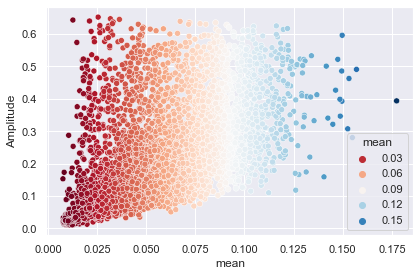

In [85]:
sns.scatterplot(
        data=descriptive_stats_error,
        x='mean',
        y='Amplitude',
        palette='RdBu',
        hue='mean')
plt.tight_layout()
plt.show()

# Plotting light curves

After understanding the descriptive statistics of the data, its time to look at how the data looks like in the form of light curves. 

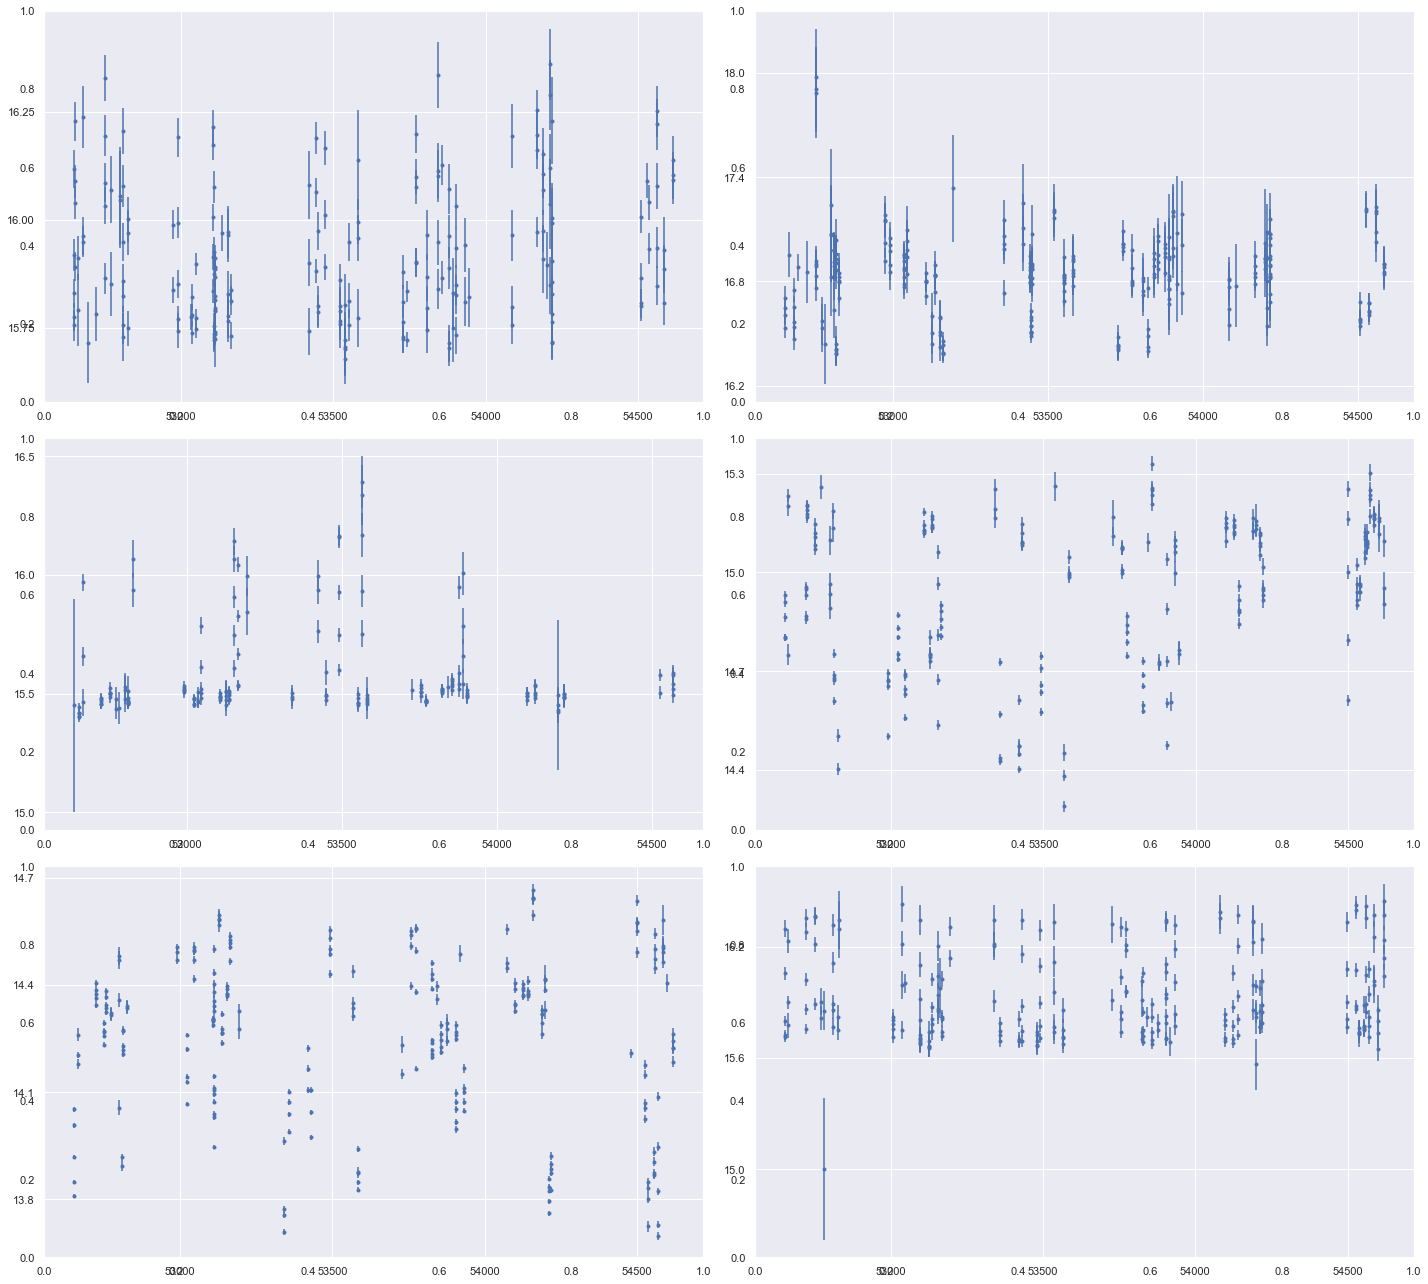

In [105]:
from matplotlib import ticker

fig, ax = plt.subplots(3,2, figsize=(20,18)) # creating subplots with 2 columms and 3 rows
ax = ax.flatten() # flatten the axes
for i in range(6):
    light_curve = data.get_light_curve(data.ids[i])
    time, mag, mag_error = light_curve.T
    ax = fig.add_subplot(321 + i)
    ax.errorbar(time, mag, mag_error, fmt='.b', ecolor='b')
    ax.xaxis.set_major_locator(ticker.MaxNLocator(5)) # 5 ticks on the x axis
    ax.yaxis.set_major_locator(ticker.MaxNLocator(4))
    
plt.tight_layout()
plt.show()